#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

2\. Реализуйте типовую архитектуру CNN для классификации изображений.

## Задачи для самостоятельного решения

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import os
import random

<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [ ] Проверено на семинаре

In [2]:
with zipfile.ZipFile("cat_breeds_4.zip", "r") as zip_ref:
    zip_ref.extractall("cat_breeds_data")
data_path = "cat_breeds_data/cat_breeds_4"

In [3]:
temp_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(data_path, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

In [4]:
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    nb_samples = 0
    for data, _ in tqdm(loader, desc="Computing mean/std"):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1) 
        mean += data.mean(dim=2).sum(dim=0)
        std += data.std(dim=2).sum(dim=0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [5]:
mean, std = compute_mean_std(temp_loader)
print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Computing mean/std: 100%|███████████████████████| 63/63 [00:08<00:00,  7.56it/s]


Mean: [0.5000261068344116, 0.45140373706817627, 0.40662744641304016]
Std: [0.23252665996551514, 0.2273934781551361, 0.22289226949214935]


In [6]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
full_dataset = datasets.ImageFolder(data_path, transform=transform)
print(f"Всего картинок: {len(full_dataset)}")
sample_img, _ = full_dataset[0]
print(f"Размер одной картинки: {sample_img.shape}")
print(f"Уникальных классов: {len(full_dataset.classes)} {full_dataset.classes}")

Всего картинок: 4000
Размер одной картинки: torch.Size([3, 300, 300])
Уникальных классов: 4 ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


In [7]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 3200, Test: 800


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

In [8]:
device = torch.device("cpu")

In [9]:
class MLPClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*300*300, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

In [10]:
num_classes = len(full_dataset.classes)
model_mlp = MLPClassifier(num_classes).to(device)
print(f"MLP params: {sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)}")

MLP params: 138372868


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

In [12]:
def accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

In [13]:
train_losses, train_accs, test_accs = [], [], []
epochs = 10  

In [15]:
for epoch in range(epochs):
    model_mlp.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model_mlp(images), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(accuracy(model_mlp, train_loader))
    test_accs.append(accuracy(model_mlp, test_loader))
    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]:.2f}%, Test Acc={test_accs[-1]:.2f}%")

Epoch 1: 100%|████████████████████████████████| 100/100 [00:33<00:00,  2.99it/s]


Epoch 1: Loss=4.3206, Train Acc=39.12%, Test Acc=31.37%


Epoch 2: 100%|████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Epoch 2: Loss=1.2666, Train Acc=45.28%, Test Acc=33.12%


Epoch 3: 100%|████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


Epoch 3: Loss=1.2167, Train Acc=46.19%, Test Acc=33.12%


Epoch 4: 100%|████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


Epoch 4: Loss=1.1826, Train Acc=49.75%, Test Acc=35.62%


Epoch 5: 100%|████████████████████████████████| 100/100 [00:32<00:00,  3.06it/s]


Epoch 5: Loss=1.1425, Train Acc=53.56%, Test Acc=37.25%


Epoch 6: 100%|████████████████████████████████| 100/100 [00:32<00:00,  3.10it/s]


Epoch 6: Loss=1.0834, Train Acc=56.25%, Test Acc=38.38%


Epoch 7: 100%|████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 7: Loss=1.0311, Train Acc=56.97%, Test Acc=35.00%


Epoch 8: 100%|████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


Epoch 8: Loss=0.9988, Train Acc=61.25%, Test Acc=33.38%


Epoch 9: 100%|████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Epoch 9: Loss=0.9691, Train Acc=60.88%, Test Acc=35.50%


Epoch 10: 100%|███████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


Epoch 10: Loss=0.9230, Train Acc=64.69%, Test Acc=35.38%


In [17]:
model_save_path = "mlp_classifier_weights.pth"
torch.save(model_mlp.state_dict(), model_save_path)
print(f"\nВеса модели MLP сохранены в файл: {model_save_path}")


Веса модели MLP сохранены в файл: mlp_classifier_weights.pth


In [16]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

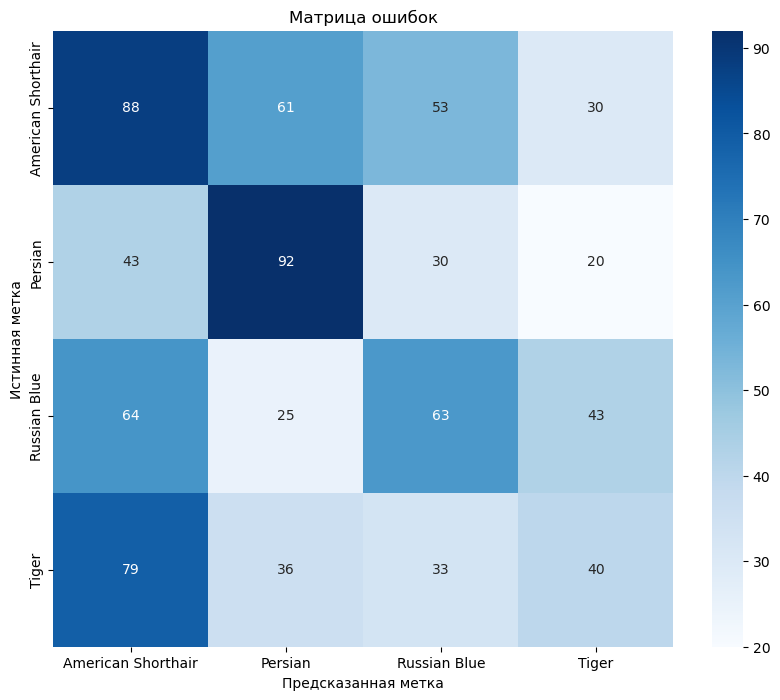

In [18]:
def make_confusion_matrix_multi_class(loader, model, class_names, device):
    """
    Строит и отображает матрицу ошибок для МНОГОКЛАССОВОЙ классификации.
    """
    with torch.inference_mode():
        predictions = []
        true_labels = []
        
        for images, labels in loader:
            images = images.to(device)
            
            outputs = model(images)
            
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.numpy())

    cm = metrics.confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(cm, 
                annot=True,    
                fmt='d',       
                cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Предсказанная метка')
    plt.ylabel('Истинная метка')
    plt.title('Матрица ошибок')
    plt.show()
make_confusion_matrix_multi_class(test_loader, model_mlp, full_dataset.classes, device)

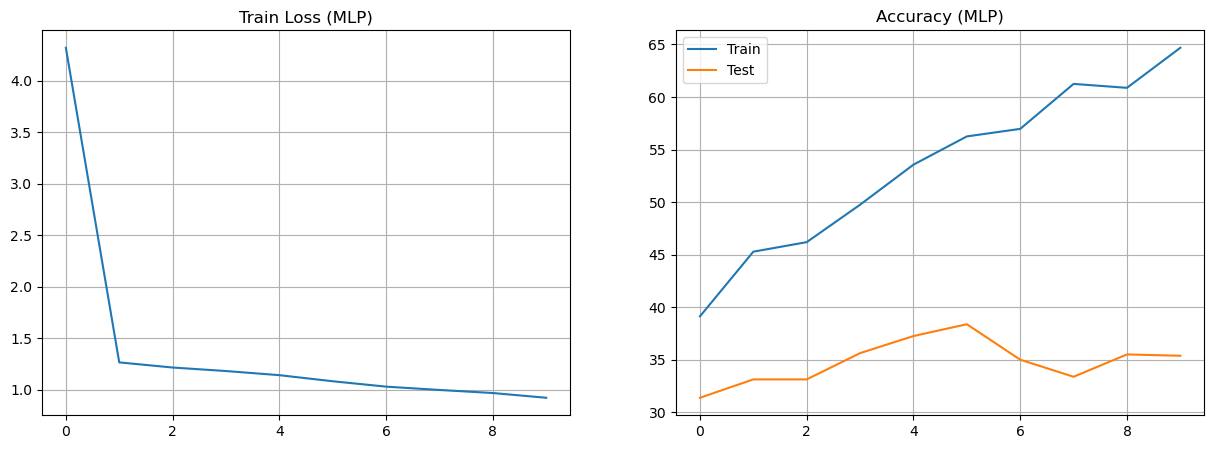

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Train Loss (MLP)")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test")
plt.legend()
plt.title("Accuracy (MLP)")
plt.grid()
plt.show()

In [20]:
print(f"Итоговая accuracy Train: {train_accs[-1]:.2f}%, Test: {test_accs[-1]:.2f}%")

Итоговая accuracy Train: 64.69%, Test: 35.38%


<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

In [21]:
def show_examples(model, dataset, k=6):
    model.eval()
    indices = random.sample(range(len(dataset)), k)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        if isinstance(dataset, Subset):
            real_idx = dataset.indices[idx]
            image, true_label = dataset.dataset[real_idx]
        else:
            image, true_label = dataset[idx]
        img_disp = image.numpy().transpose(1,2,0)
        img_disp = img_disp * np.array(std.tolist()) + np.array(mean.tolist())
        img_disp = np.clip(img_disp, 0, 1)
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            pred = output.argmax(1).item()
        axes[i].imshow(img_disp)
        axes[i].set_title(f"True: {full_dataset.classes[true_label]}\nPred: {full_dataset.classes[pred]}",
                          color="green" if true_label==pred else "red")
        axes[i].axis("off")
    plt.tight_layout(); plt.show()

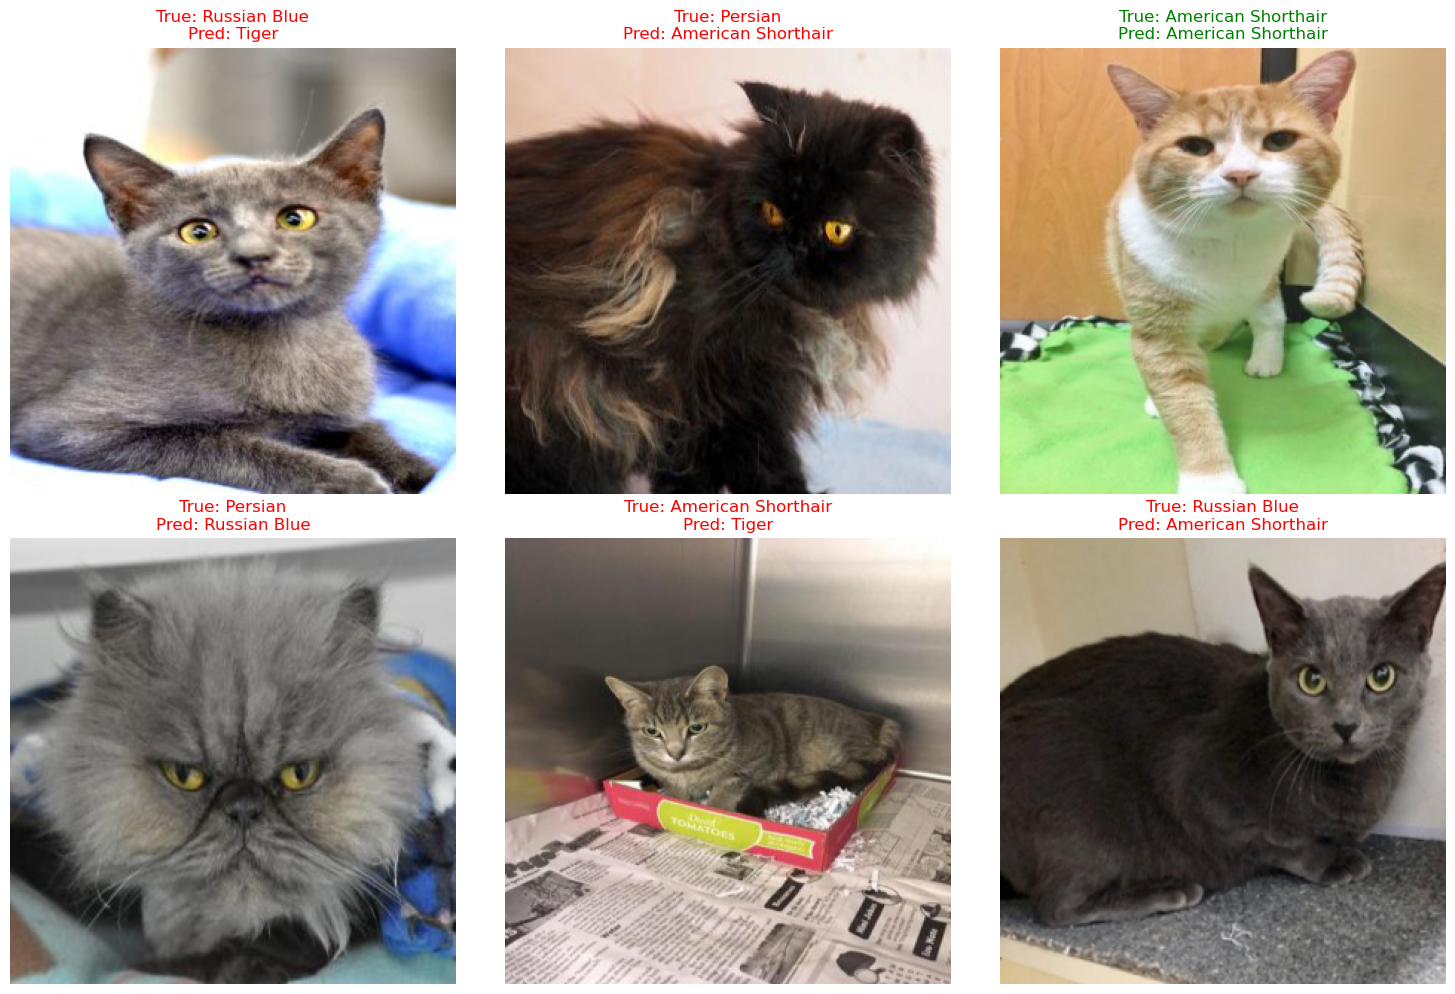

In [22]:
show_examples(model_mlp, test_dataset, k=6)

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

In [23]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*37*37, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
model_cnn = CNNClassifier(num_classes).to(device)
print(f"CNN params: {sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)}")

CNN params: 44953924


In [25]:
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
train_losses_cnn, train_accs_cnn, test_accs_cnn = [], [], []
epochs = 10

In [26]:
for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"CNN Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        loss = criterion(model_cnn(images), labels)
        loss.backward()
        optimizer_cnn.step()
        running_loss += loss.item()
    train_losses_cnn.append(running_loss / len(train_loader))
    train_accs_cnn.append(accuracy(model_cnn, train_loader))
    test_accs_cnn.append(accuracy(model_cnn, test_loader))
    print(f"Epoch {epoch+1}: Loss={train_losses_cnn[-1]:.4f}, Train Acc={train_accs_cnn[-1]:.2f}%, Test Acc={test_accs_cnn[-1]:.2f}%")

CNN Epoch 1: 100%|████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


Epoch 1: Loss=1.6663, Train Acc=37.41%, Test Acc=33.62%


CNN Epoch 2: 100%|████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


Epoch 2: Loss=1.3066, Train Acc=40.28%, Test Acc=36.38%


CNN Epoch 3: 100%|████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


Epoch 3: Loss=1.2722, Train Acc=44.84%, Test Acc=39.38%


CNN Epoch 4: 100%|████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


Epoch 4: Loss=1.2344, Train Acc=47.19%, Test Acc=39.88%


CNN Epoch 5: 100%|████████████████████████████| 100/100 [16:32<00:00,  9.93s/it]


Epoch 5: Loss=1.0961, Train Acc=69.31%, Test Acc=47.12%


CNN Epoch 6: 100%|████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]


Epoch 6: Loss=0.8526, Train Acc=75.75%, Test Acc=47.25%


CNN Epoch 7: 100%|████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]


Epoch 7: Loss=0.5574, Train Acc=92.50%, Test Acc=46.50%


CNN Epoch 8: 100%|████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Epoch 8: Loss=0.2520, Train Acc=96.78%, Test Acc=45.00%


CNN Epoch 9: 100%|████████████████████████████| 100/100 [02:13<00:00,  1.34s/it]


Epoch 9: Loss=0.1200, Train Acc=99.00%, Test Acc=43.88%


CNN Epoch 10: 100%|███████████████████████████| 100/100 [49:01<00:00, 29.41s/it]


Epoch 10: Loss=0.0450, Train Acc=99.47%, Test Acc=44.25%


In [27]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [28]:
model_save_path_cnn = "cnn_classifier_weights.pth"
torch.save(model_cnn.state_dict(), model_save_path_cnn)
print(f"Веса модели CNN сохранены в файл: {model_save_path_cnn}")

Веса модели CNN сохранены в файл: cnn_classifier_weights.pth


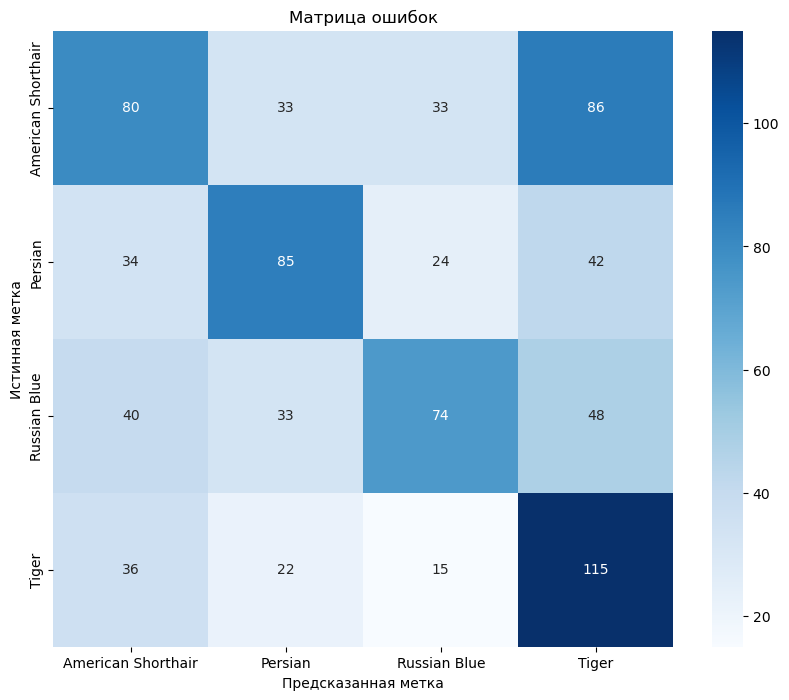

In [29]:
make_confusion_matrix_multi_class(test_loader, model_cnn, full_dataset.classes, device)

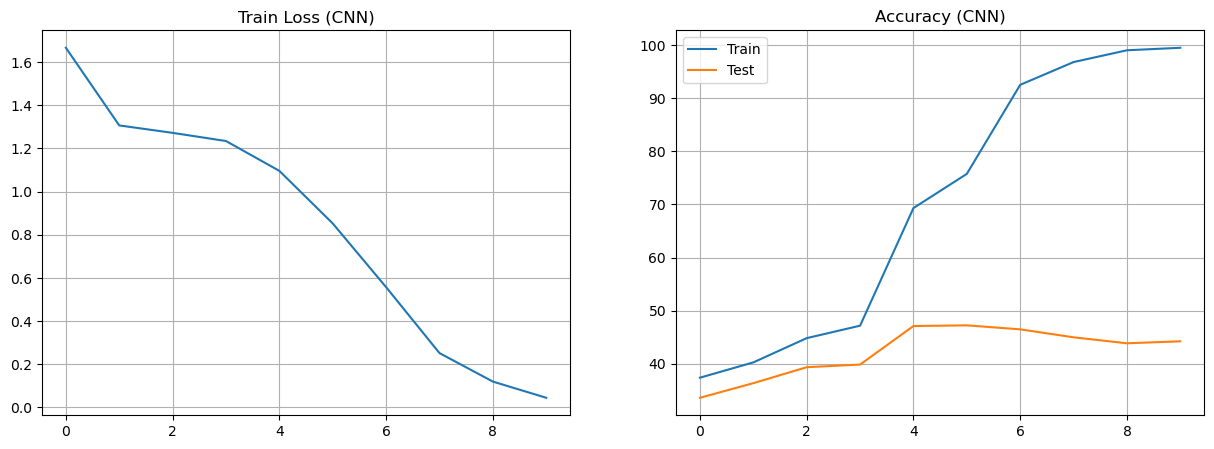

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_cnn)
plt.title("Train Loss (CNN)")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(train_accs_cnn, label="Train")
plt.plot(test_accs_cnn, label="Test")
plt.legend()
plt.title("Accuracy (CNN)")
plt.grid()
plt.show()

In [31]:
print(f"Итоговая accuracy Train: {train_accs_cnn[-1]:.2f}%, Test: {test_accs_cnn[-1]:.2f}%")

Итоговая accuracy Train: 99.47%, Test: 44.25%


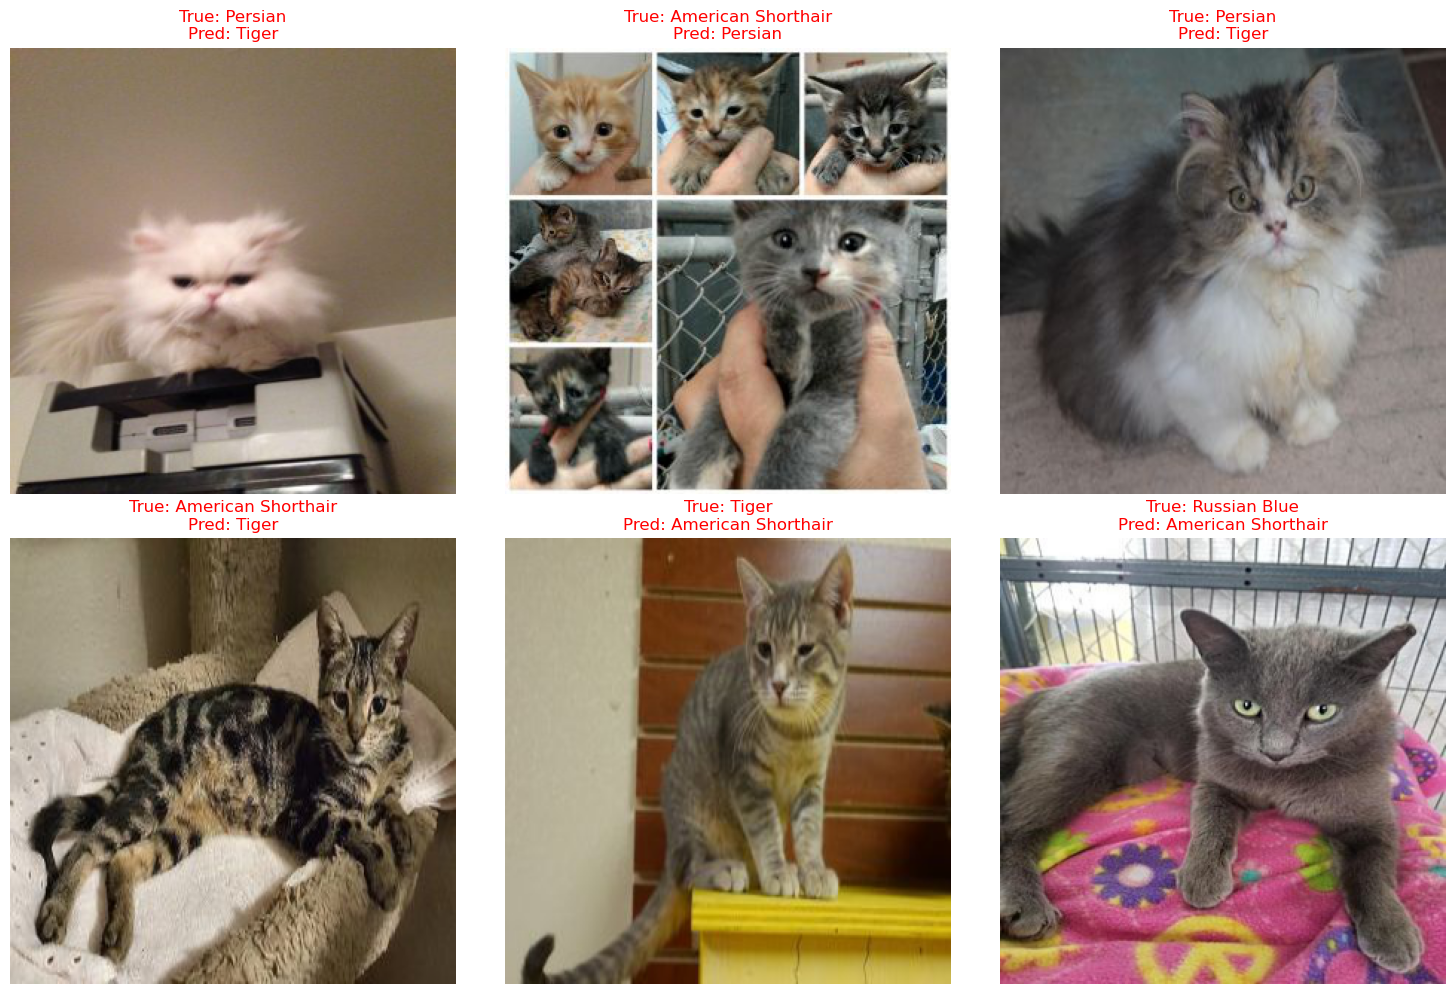

In [32]:
show_examples(model_cnn, test_dataset, k=6)

<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

In [31]:
def visualize_conv_kernels(model, layer_name="conv1"):
    kernels = getattr(model, layer_name).weight.data.cpu()
    kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())
    n_kernels = kernels.shape[0]
    rows = n_kernels // 8 + 1
    plt.figure(figsize=(10, 2*rows))
    for i in range(n_kernels):
        plt.subplot(rows, 8, i+1)
        plt.imshow(kernels[i].permute(1,2,0))
        plt.axis("off")
        plt.title(f"K {i+1}")
    plt.tight_layout(); plt.show()

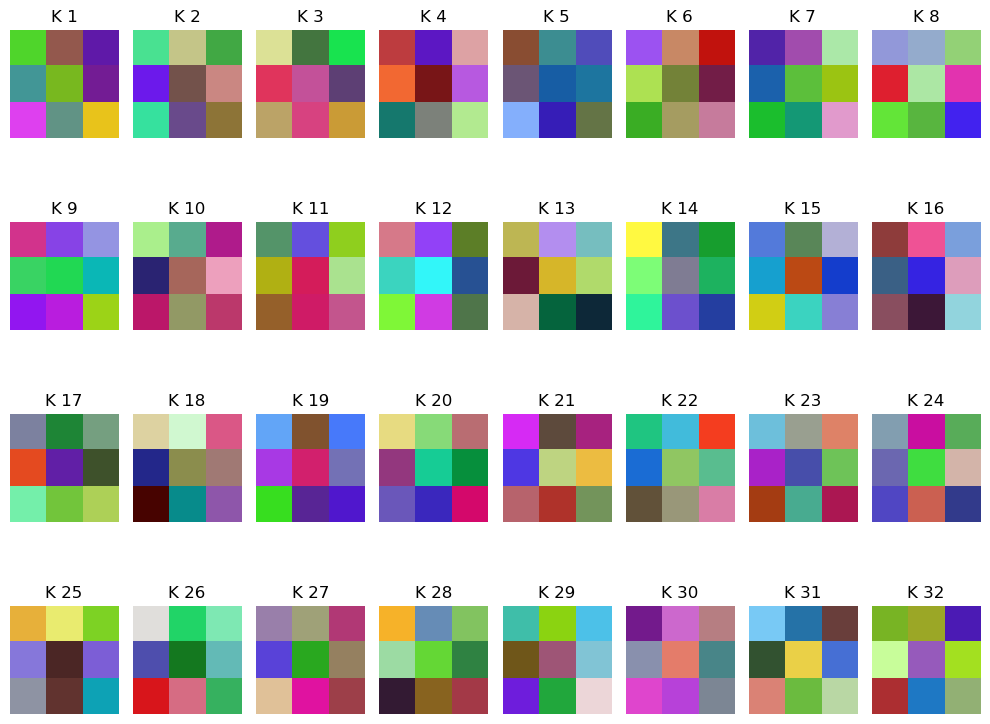

In [46]:
visualize_conv_kernels(model_cnn, "conv1")

In [32]:
def visualize_feature_maps(model, dataset, idx=0):
    image, _ = dataset[idx] if not isinstance(dataset, Subset) else dataset.dataset[dataset.indices[idx]]
    x = image.unsqueeze(0).to(device)
    hooks = {}
    def hook_fn(m, i, o): hooks["fm"] = o.detach().cpu()
    h = model.conv1.register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad(): _ = model(x)
    h.remove()
    fm = hooks["fm"].squeeze()
    n_maps = min(fm.shape[0], 16)
    plt.figure(figsize=(14, 4))
    for i in range(n_maps):
        plt.subplot(2, n_maps//2, i+1)
        plt.imshow(fm[i].numpy(), cmap="viridis")
        plt.axis("off")
        plt.title(f"FM {i+1}")
    plt.tight_layout(); plt.show()

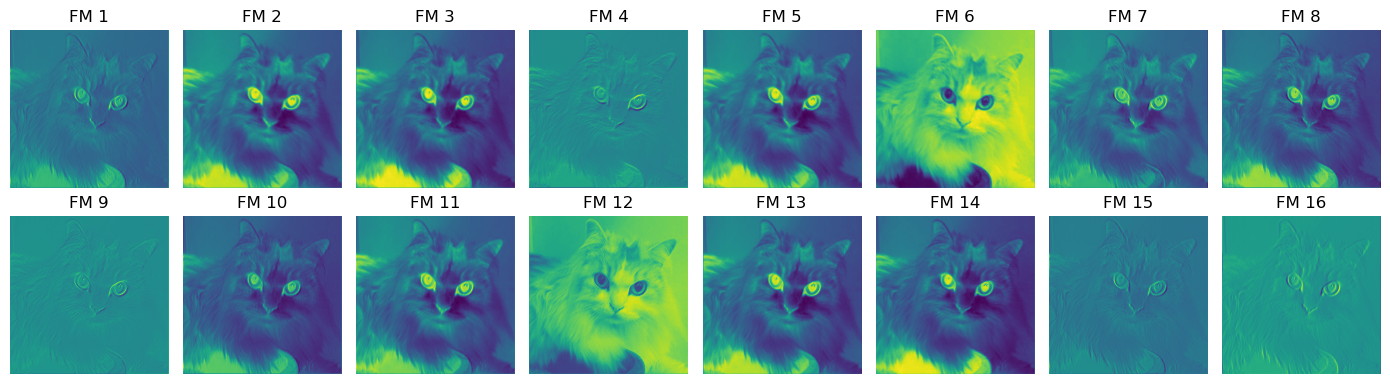

In [33]:
visualize_feature_maps(model_cnn, test_dataset, idx=0)

## Обратная связь
- [ ] Хочу получить обратную связь по решению